In [1]:
import numpy as np
import json
from itertools import product

In [2]:
data = json.load(open("/home/tom/Programming/SCONE/InputFiles/output.json"))

In [3]:
current_data = data["active"]["current"]
current_matrix = np.array(current_data["JM"])

transport_data = data["active"]["TransportXS"]
transportXS_matrix = np.array(transport_data["transportXS"])
totalXS_matrix = np.array(transport_data["totalXS"])
raw_scatterXS = np.array(transport_data["scatterXS"])
scatterXS_matrix = np.array(transport_data["scatteringProductionXS"])
fissionXS_matrix = np.array(transport_data["fissionProductionXS"])
raw_fissionXS = np.array(transport_data["fissionXS"])
nu_bar_matrix = np.array(transport_data["nuBar"])
flux_matrix = np.array(data["active"]["fluxMap"]["Res"])

# TODO: properly extract spacing
spacing = [2, 50/10, 2]

beta = 1

In [4]:
flux_matrix.shape

(1, 10, 1, 1, 1, 2)

In [5]:
current_max_x = len(current_data["XBounds"]) + 1
current_max_y = len(current_data["YBounds"]) + 1
current_max_z = len(current_data["ZBounds"]) + 1
current_max_energy_group = len(transport_data["EnergyBounds"][0])

mesh_size_x = len(current_data["XBounds"])
mesh_size_y = len(current_data["YBounds"])
mesh_size_z = len(current_data["ZBounds"])

In [6]:
print(current_matrix.shape)
print(flux_matrix.shape)
print(transportXS_matrix.shape)

print(scatterXS_matrix.shape)
print(fissionXS_matrix.shape)

print()

for i0, i0_l in enumerate(current_matrix):
    for i1, i1_l in enumerate(i0_l):
        for i2, i2_l in enumerate(i1_l):
            for i3, i3_l in enumerate(i2_l):
                for i4, i4_l in enumerate(i3_l):
                    if current_matrix[i0, i1, i2, i3, i4, 0]:
                        print(i0, i1, i2, i3, i4, 0, current_matrix[i0, i1, i2, i3, i4, 0])


(1, 3, 2, 11, 2, 2)
(1, 10, 1, 1, 1, 2)
(1, 10, 1, 1, 2)
(1, 10, 1, 1, 1, 2)
(1, 10, 1, 1, 1, 2)

0 1 1 1 1 0 -9.92475
0 1 1 2 1 0 2.03102
0 1 1 3 1 0 -31.0134
0 1 1 4 1 0 14.2799
0 1 1 5 1 0 -1.64173
0 1 1 6 1 0 -13.1152
0 1 1 7 1 0 -19.375
0 1 1 8 1 0 -1.17141
0 1 1 9 1 0 4.02609


In [7]:
def print_matrix(matrix):
    return
    for row in matrix:
        for item in row:
            rounded = round(item, 4)
            if item == 0:
                print(f"{'--':<8}", end=" ")
            else:
                print(f"{rounded:<8}", end=" ")
        print("\n")

In [8]:
def get_current_on_cell_boundary_plus_half(direction, x, y, z, energy_group):
    # coord, direction, energy, mean/ std
    return current_matrix[energy_group, direction, z + 1, y + 1, x + 1, 0] / ((spacing[0] * spacing[1] * spacing[2]) / spacing[direction])

def get_flux_at_coordinate(x, y, z, energy_group):
    return flux_matrix[z, y, x, energy_group, 0, 0] / (spacing[0] * spacing[1] * spacing[2])

def get_transportXS_at_coordinate(x, y, z, energy_group):
    return transportXS_matrix[z, y, x, energy_group, 0]

def get_totalXS_at_coordinate(x, y, z, energy_group):
    return totalXS_matrix[z, y, x, energy_group, 0]

def get_scatter_xs(energy_to, energy_from, x, y, z):
    # TODO: check this
    return scatterXS_matrix[z, y, x, energy_from, energy_to, 0]

def get_raw_scatter_xs(energy, x, y, z):
    # TODO: check this
    return raw_scatterXS[z, y, x, energy, 0]

def get_raw_fission_xs(energy, x, y, z):
    # TODO: check this
    return raw_fissionXS[z, y, x, energy, 0]

def get_nu_bar(energy, x, y, z):
    # TODO: check this
    return nu_bar_matrix[z, y, x, energy, 0]

def get_fission_xs(energy_to, energy_from, x, y, z):
    # TODO: check this
    return fissionXS_matrix[z, y, x, energy_from, energy_to, 0]

In [9]:
# print(get_raw_scatter_xs(0, 0, 5, 0))
# print(get_scatter_xs(0, 0, 0, 5, 0))

# print()

# print(get_raw_fission_xs(0, 0, 5, 0))
# print(get_fission_xs(0, 0, 0, 5, 0))
# print(get_nu_bar(0, 0, 5, 0))

# print()

# print(get_transportXS_at_coordinate(0, 5, 0, 0))
# print(get_totalXS_at_coordinate(0, 5, 0, 0))

In [10]:
# # Calculate k_inf
# # Do I need to remove scattering multiplicity here?
# absorption_xs = get_totalXS_at_coordinate(0, 5, 0, 0) - get_scatter_xs(0, 0, 0, 5, 0)
# print(absorption_xs)

# # Assume utilization factor = 1

# eta = get_nu_bar(0, 0, 5, 0) * get_fission_xs(0, 0, 0, 5, 0) / absorption_xs
# k_inf = eta * absorption_xs
# print(eta)

In [11]:
diffusion_coefficient = np.zeros((mesh_size_x, mesh_size_y, mesh_size_z, current_max_energy_group))

for x, y, z, energy in product(range(mesh_size_x), range(mesh_size_y), range(mesh_size_z), range(current_max_energy_group)):
    transport_XS = get_transportXS_at_coordinate(x, y, z, energy)
    assert transport_XS > 0
    diffusion_coefficient[x, y, z, energy] = 1.0 / (3.0 * transport_XS)


In [12]:
def build_linear_diffusive_term(direction):
    linear_diffusive_term_positive = np.zeros((mesh_size_x, mesh_size_y, mesh_size_z, current_max_energy_group))
    linear_diffusive_term_negative = np.zeros((mesh_size_x, mesh_size_y, mesh_size_z, current_max_energy_group))

    for x, y, z, energy in product(range(mesh_size_x), range(mesh_size_y), range(mesh_size_z), range(current_max_energy_group)):
        D = diffusion_coefficient[x, y, z, energy]

        is_on_high_boundary = [x == mesh_size_x - 1, y == mesh_size_y - 1, z == mesh_size_z - 1][direction]
        is_on_low_boundary = [x == 0, y == 0, z == 0][direction]
        delta_x, delta_y, delta_z = [(1, 0, 0), (0, 1, 0), (0, 0, 1)][direction]

        if is_on_low_boundary:
            coupling = (2 * D * (1 - beta)) / (4 * D * (1 + beta) + (1 - beta) * spacing[direction])
        else:
            D_minus_1 = diffusion_coefficient[x - delta_x, y - delta_y, z - delta_z, energy]
            coupling = (2 * D_minus_1 * D) / ((D_minus_1 + D) * spacing[direction])

        linear_diffusive_term_negative[x, y, z, energy] = coupling

        if is_on_high_boundary:
            coupling = (2 * D * (1 - beta)) / (4 * D * (1 + beta) + (1 - beta) * spacing[direction])
        else:
            D_plus_1 = diffusion_coefficient[x + delta_x, y + delta_y, z + delta_z, energy]
            coupling = (2 * D_plus_1 * D) / ((D_plus_1 + D) * spacing[direction])
        
        linear_diffusive_term_positive[x, y, z, energy] = coupling
    return linear_diffusive_term_negative, linear_diffusive_term_positive

In [13]:
POSITIVE_DIR = 1
NEGATIVE_DIR = 0
linear_diffusive_terms = [build_linear_diffusive_term(0), build_linear_diffusive_term(1), build_linear_diffusive_term(2)]

In [14]:
def build_non_linear_diffusive_term(direction):
    non_linear_diffusive_term_positive = np.zeros((mesh_size_x, mesh_size_y, mesh_size_z, current_max_energy_group))
    non_linear_diffusive_term_negative = np.zeros((mesh_size_x, mesh_size_y, mesh_size_z, current_max_energy_group))

    for x, y, z, energy in product(range(mesh_size_x), range(mesh_size_y), range(mesh_size_z), range(current_max_energy_group)):
        flux = get_flux_at_coordinate(x, y, z, energy)

        is_on_high_boundary = [x == mesh_size_x - 1, y == mesh_size_y - 1, z == mesh_size_z - 1][direction]
        is_on_low_boundary = [x == 0, y == 0, z == 0][direction]
        delta_x, delta_y, delta_z = [(1, 0, 0), (0, 1, 0), (0, 0, 1)][direction]

        J_minus_half_tallied = get_current_on_cell_boundary_plus_half(direction, x - delta_x, y - delta_y, z - delta_z, energy)
        D_linear = linear_diffusive_terms[direction][NEGATIVE_DIR][x, y, z, energy]

        if is_on_low_boundary:
            non_linear_term = (J_minus_half_tallied + D_linear * flux) / flux
        else:
            flux_minus_1 = get_flux_at_coordinate(x - delta_x, y - delta_y, z - delta_z, energy)

            print(f"Current-: {J_minus_half_tallied}, Linear estimate: {-D_linear * (-flux_minus_1 + flux)}")
            non_linear_term = (J_minus_half_tallied + D_linear * (-flux_minus_1 + flux)) / (flux_minus_1 + flux)

        non_linear_diffusive_term_negative[x, y, z, energy] = non_linear_term

        J_plus_half_tallied = get_current_on_cell_boundary_plus_half(direction, x, y, z, energy)
        D_linear = linear_diffusive_terms[direction][POSITIVE_DIR][x, y, z, energy]
        if is_on_high_boundary:
            non_linear_term = (J_plus_half_tallied - D_linear * flux) / flux
        else:
            flux_plus_1 = get_flux_at_coordinate(x + delta_x, y + delta_y, z + delta_z, energy)

            print(f"Current+: {J_plus_half_tallied}, Linear estimate: {-D_linear * (flux_plus_1 - flux)}")
            non_linear_term = (J_plus_half_tallied + D_linear * (flux_plus_1 - flux)) / (flux_plus_1 + flux)
        
        non_linear_diffusive_term_positive[x, y, z, energy] = non_linear_term


        non_linear_diffusive_term_negative[x, y, z, energy] = 0
        non_linear_diffusive_term_positive[x, y, z, energy] = 0

    return non_linear_diffusive_term_negative, non_linear_diffusive_term_positive

In [15]:
non_linear_diffusive_terms = [build_non_linear_diffusive_term(0), build_non_linear_diffusive_term(1), build_non_linear_diffusive_term(2)]

Current+: -2.4811875, Linear estimate: -0.8256251764352196
Current-: -2.4811875, Linear estimate: -0.8256251764352196
Current+: 0.507755, Linear estimate: 1.1185528493300143
Current-: 0.507755, Linear estimate: 1.1185528493300143
Current+: -7.75335, Linear estimate: -2.737875997544503
Current-: -7.75335, Linear estimate: -2.737875997544503
Current+: 3.569975, Linear estimate: 0.557744315562668
Current-: 3.569975, Linear estimate: 0.557744315562668
Current+: -0.4104325, Linear estimate: 0.3420327830348864
Current-: -0.4104325, Linear estimate: 0.3420327830348864
Current+: -3.2788, Linear estimate: -1.028318173525023
Current-: -3.2788, Linear estimate: -1.028318173525023
Current+: -4.84375, Linear estimate: -0.1829582963246018
Current-: -4.84375, Linear estimate: -0.1829582963246018
Current+: -0.2928525, Linear estimate: 1.3770973627649732
Current-: -0.2928525, Linear estimate: 1.3770973627649732
Current+: 1.0065225, Linear estimate: 1.2147069711864589
Current-: 1.0065225, Linear estimat

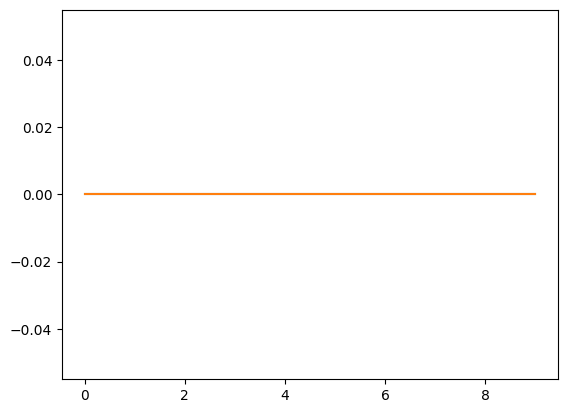

In [16]:
from matplotlib import pyplot as plt

for x, z, energy in product(range(mesh_size_x), range(mesh_size_z), range(current_max_energy_group)):
    plt.plot(non_linear_diffusive_terms[1][POSITIVE_DIR][x, :, z, 0])
    plt.plot(non_linear_diffusive_terms[1][NEGATIVE_DIR][x, :, z, 0])

In [17]:
print(flux_matrix[0, :, 0, 0, 0, 0])

[57831.7 58282.1 57672.1 59166.2 58861.9 58675.5 59236.3 59336.1 58585.5
 57922.7]


In [18]:
# Generate neutron loss matrix

delta_test = 0
number_of_groups = mesh_size_x * mesh_size_y * mesh_size_z * current_max_energy_group
neutron_loss_matrix = np.zeros((number_of_groups, number_of_groups))

def get_index_in_flattened_flux_vector(energy, x, y, z):
    return energy * (mesh_size_x * mesh_size_y * mesh_size_z) + z * (mesh_size_y * mesh_size_x) + y * mesh_size_x + x

for x, y, z, energy in product(range(mesh_size_x), range(mesh_size_y), range(mesh_size_z), range(current_max_energy_group)):
    index_in_flattened_flux_vector = get_index_in_flattened_flux_vector(energy, x, y, z)

    for direction in range(3):
        spacing_inv = (1 / spacing[direction])

        is_on_high_boundary = [x == mesh_size_x - 1, y == mesh_size_y - 1, z == mesh_size_z - 1][direction]
        is_on_low_boundary = [x == 0, y == 0, z == 0][direction]
        delta_x, delta_y, delta_z = [(1, 0, 0), (0, 1, 0), (0, 0, 1)][direction]    

        # From flux l-1
        D_linear_minus = linear_diffusive_terms[direction][NEGATIVE_DIR][x, y, z, energy]
        D_linear_plus = linear_diffusive_terms[direction][POSITIVE_DIR][x, y, z, energy]

        D_non_linear_minus = non_linear_diffusive_terms[direction][NEGATIVE_DIR][x, y, z, energy]
        D_non_linear_plus = non_linear_diffusive_terms[direction][POSITIVE_DIR][x, y, z, energy]

        print("group")
        if not is_on_low_boundary:
            neutron_loss_matrix[index_in_flattened_flux_vector, get_index_in_flattened_flux_vector(energy, x - delta_x, y - delta_y, z - delta_z)] \
                += spacing_inv * (-D_linear_minus - D_non_linear_minus) \
                    + delta_test
            print(f"{D_linear_minus=}")

        # From flux l
        neutron_loss_matrix[index_in_flattened_flux_vector, index_in_flattened_flux_vector] \
            += spacing_inv * (D_linear_minus + D_linear_plus - D_non_linear_minus + D_non_linear_plus) \
                + delta_test
        print(f"{(D_linear_minus + D_linear_plus)=}")

        # From flux l+1
        if not is_on_high_boundary:
            neutron_loss_matrix[index_in_flattened_flux_vector, get_index_in_flattened_flux_vector(energy, x + delta_x, y + delta_y, z + delta_z)] \
                += spacing_inv * (-D_linear_plus + D_non_linear_plus) \
                    + delta_test
            print(f"{(D_linear_plus)=}")

    # Total XS
    neutron_loss_matrix[index_in_flattened_flux_vector, index_in_flattened_flux_vector] \
        += get_totalXS_at_coordinate(x, y, z, energy) \
            + delta_test

    # Scattering
    for h_energy in range(current_max_energy_group):
        neutron_loss_matrix[index_in_flattened_flux_vector, get_index_in_flattened_flux_vector(h_energy, x, y, z)] \
            -= get_scatter_xs(energy, h_energy, x, y, z) \
                - delta_test

group
(D_linear_minus + D_linear_plus)=0.0
group
(D_linear_minus + D_linear_plus)=0.03666186396248758
(D_linear_plus)=0.03666186396248758
group
(D_linear_minus + D_linear_plus)=0.0
group
(D_linear_minus + D_linear_plus)=0.0
group
D_linear_minus=0.03666186396248758
(D_linear_minus + D_linear_plus)=0.07333572787494706
(D_linear_plus)=0.036673863912459484
group
(D_linear_minus + D_linear_plus)=0.0
group
(D_linear_minus + D_linear_plus)=0.0
group
D_linear_minus=0.036673863912459484
(D_linear_minus + D_linear_plus)=0.07332303060203188
(D_linear_plus)=0.03664916668957239
group
(D_linear_minus + D_linear_plus)=0.0
group
(D_linear_minus + D_linear_plus)=0.0
group
D_linear_minus=0.03664916668957239
(D_linear_minus + D_linear_plus)=0.07330669646694205
(D_linear_plus)=0.036657529777369656
group
(D_linear_minus + D_linear_plus)=0.0
group
(D_linear_minus + D_linear_plus)=0.0
group
D_linear_minus=0.036657529777369656
(D_linear_minus + D_linear_plus)=0.07335632624033965
(D_linear_plus)=0.036698796462

In [19]:
linear_diffusive_terms[1][NEGATIVE_DIR][0, :, 0, 0]

array([0.        , 0.03666186, 0.03667386, 0.03664917, 0.03665753,
       0.0366988 , 0.03667326, 0.03666499, 0.03669324, 0.0366538 ])

In [20]:
# Generate neutron production matrix
neutron_production_matrix = np.zeros((number_of_groups, number_of_groups))

for x, y, z, energy in product(range(mesh_size_x), range(mesh_size_y), range(mesh_size_z), range(current_max_energy_group)):
    index_in_flattened_flux_vector = get_index_in_flattened_flux_vector(energy, x, y, z)
    for energy_group_h in range(current_max_energy_group):
        neutron_production_matrix[index_in_flattened_flux_vector, get_index_in_flattened_flux_vector(energy_group_h, x, y, z)] \
            += get_nu_bar(energy, x, y, z) * get_fission_xs(energy, energy_group_h, x, y, z)


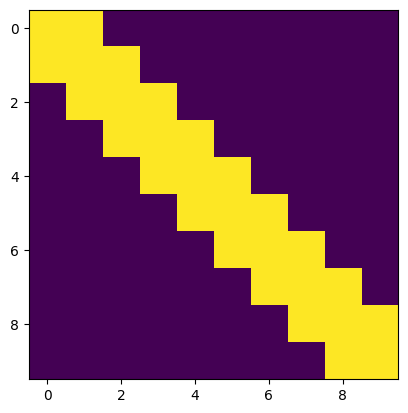

In [21]:
import matplotlib.pyplot as plt

plt.imshow((neutron_loss_matrix != 0))

print_matrix(neutron_loss_matrix)


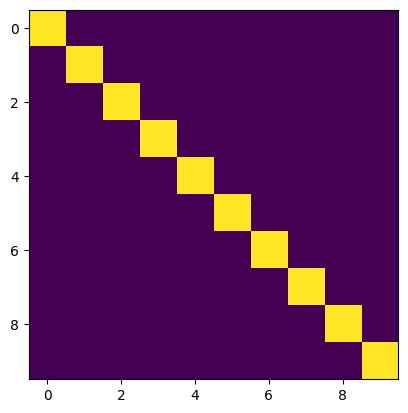

In [22]:
import matplotlib.pyplot as plt

plt.imshow(neutron_production_matrix != 0)

print_matrix(neutron_production_matrix)

In [23]:
from scipy.linalg import eig

eigenvalues, eigenvectors = eig(neutron_loss_matrix, neutron_production_matrix, check_finite=True)

In [24]:
def convert_flattened_flux_into_matrix(flattened_flux):
    matrix = np.zeros((mesh_size_x, mesh_size_y, mesh_size_z, current_max_energy_group))
    for x, y, z, energy in product(range(mesh_size_x), range(mesh_size_y), range(mesh_size_z), range(current_max_energy_group)):
        index = get_index_in_flattened_flux_vector(energy, x, y, z)
        matrix[x, y, z, energy] = flattened_flux[index]
    return matrix

[[ 0.07040754 -0.13390914  0.20213908 -0.26222558  0.31711371 -0.36066845
   0.3976194   0.3308796   0.44443556  0.41351976]
 [-0.20525351  0.35236589 -0.44243382  0.42645399 -0.32029678  0.14194916
   0.06639607  0.32825398  0.39718896  0.25209685]
 [ 0.32259023 -0.44088724  0.32402478 -0.00541062 -0.31317773  0.44624097
  -0.32023931  0.32161445  0.30608037 -0.00863565]
 [-0.40586531  0.35779336  0.06390896 -0.42345595  0.31787966  0.13651947
  -0.44567892  0.31747979  0.18721947 -0.26631207]
 [ 0.44584964 -0.1352168  -0.39860498  0.262351    0.31573089 -0.36101903
  -0.20704908  0.31544931  0.05124533 -0.42405033]
 [-0.43738569 -0.14011168  0.40051302  0.26470138 -0.31372764 -0.36292719
   0.1993531   0.31728438 -0.08898187 -0.42487866]
 [ 0.389387    0.36326293 -0.07572969 -0.42755627 -0.31339187  0.14085307
   0.43983844  0.31597257 -0.21968439 -0.25926379]
 [-0.31148471 -0.45545948 -0.30996013  0.00648422  0.31947221  0.4472977
   0.31038422  0.30958918 -0.32527784  0.00970811]
 

/home/tom/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


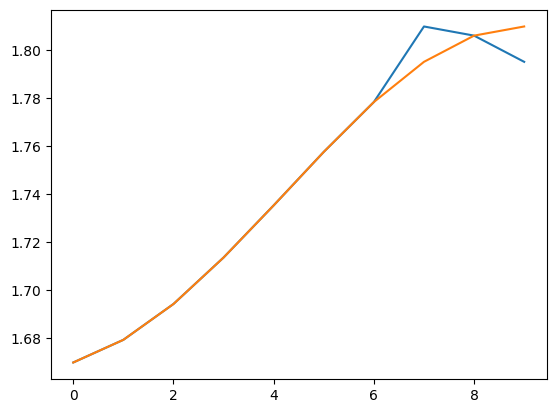

In [25]:
plt.plot(1 / np.array(eigenvalues))
plt.plot(sorted(1 / np.array(eigenvalues)))
print(eigenvectors)

In [26]:
# From stackoverflow
def gauss_seidel(A, b, tolerance, max_iterations, x):
    #x is the initial condition
    iter1 = 0
    #Iterate
    for k in range(max_iterations):
        iter1 = iter1 + 1
        x_old  = x.copy()
        
        #Loop over rows
        for i in range(A.shape[0]):
            x[i] = (b[i] - np.dot(A[i,:i], x[:i]) - np.dot(A[i,(i+1):], x_old[(i+1):])) / A[i ,i]
            
        #Stop condition 
        #LnormInf corresponds to the absolute value of the greatest element of the vector.
        
        LnormInf = max(abs((x - x_old)))/max(abs(x_old))   
        if  LnormInf < tolerance:
            break
    return x

# From openmc

def _check_convergence(s_n, s_o, k_n, k_o, iteration, innerits):
    """Checks the convergence of the CMFD problem

    Parameters
    ----------
    s_n : numpy.ndarray
        Source vector from current iteration
    s_o : numpy.ndarray
        Source vector from previous iteration
    k_n : float
        K-effective  from current iteration
    k_o : float
        K-effective from previous iteration
    iteration : int
        Iteration number
    innerits : int
        Number of iterations required for convergence in inner GS loop

    Returns
    -------
    iconv : bool
        Whether the power iteration has reached convergence
    serr : float
        Error in source from previous iteration to current iteration, used
        for dominance ratio calculations

    """
    # Calculate error in keff
    kerr = abs(k_o - k_n) / k_n

    # Calculate max error in source
    with np.errstate(divide='ignore', invalid='ignore'):
        serr = np.sqrt(np.sum(np.where(s_n > 0, ((s_n-s_o) / s_n)**2, 0))
                        / len(s_n))

    # Check for convergence
    iconv = kerr < 1.e-5 and serr < 1.e-4

    return iconv, serr

def _execute_power_iter(loss, prod):
    """Main power iteration routine for the CMFD calculation

    Parameters
    ----------
    loss : scipy.sparse.spmatrix
        Sparse matrix storing elements of CMFD loss matrix
    prod : scipy.sparse.spmatrix
        Sparse matrix storing elements of CMFD production matrix

    Returns
    -------
    phi_n : numpy.ndarray
        Flux vector of CMFD problem
    k_n : float
        Eigenvalue of CMFD problem
    dom : float
        Dominance ratio of CMFD problem

    """
    # Get problem size
    n = loss.shape[0]

    # Set up tolerances for C++ solver
    atoli = 1.e-10
    rtoli = 1.e-5
    toli = rtoli * 100

    # Set up flux vectors, intital guess set to 1
    phi_n = np.ones((n,))
    phi_o = np.ones((n,))

    # Set up source vectors
    s_n = np.zeros((n,))
    s_o = np.zeros((n,))

    # Set initial guess
    k_n = 1.5
    k_o = k_n
    dw = 1.e6
    k_s = k_o + dw
    k_ln = 1.0/(1.0/k_n - 1.0/k_s)
    k_lo = k_ln

    # Set norms to 0
    norm_n = 0.0
    norm_o = 0.0

    # Maximum number of power iterations
    maxits = 10000

    # Perform Wielandt shift
    loss -= 1.0/k_s*prod

    # Begin power iteration
    for i in range(maxits):
        if i % 20 == 0:
            print(f"Iteration {i}")
        # Check if reach max number of iterations
        if i == maxits - 1:
            raise RuntimeError('Reached maximum iterations in CMFD power '
                                'iteration solver.')

        # Compute source vector
        s_o = prod.dot(phi_o)

        # Normalize source vector
        s_o /= k_lo

        # Compute new flux with C++ solver
        innerits = gauss_seidel(loss, s_o, toli, 10000, phi_n)

        # Compute new source vector
        s_n = prod.dot(phi_n)

        # Compute new shifted eigenvalue
        k_ln = np.sum(s_n) / np.sum(s_o)

        # Compute new eigenvalue
        k_n = 1.0/(1.0/k_ln + 1.0/k_s)

        # Renormalize the old source
        s_o *= k_lo

        # Check convergence
        iconv, norm_n = _check_convergence(s_n, s_o, k_n, k_o, i+1, innerits)

        # If converged, calculate dominance ratio and break from loop
        if iconv:
            dom = norm_n / norm_o
            return phi_n, k_n, dom

        # Record old values if not converged
        phi_o = phi_n
        k_o = k_n
        k_lo = k_ln
        norm_o = norm_n

        # Update tolerance for inner iterations
        toli = max(atoli, rtoli*norm_n)

In [27]:
mc_flux, mc_k, dominance = _execute_power_iter(neutron_loss_matrix, neutron_production_matrix)

Iteration 0
Iteration 20
Iteration 40


In [28]:
print(mc_k)

1.8099373076663248


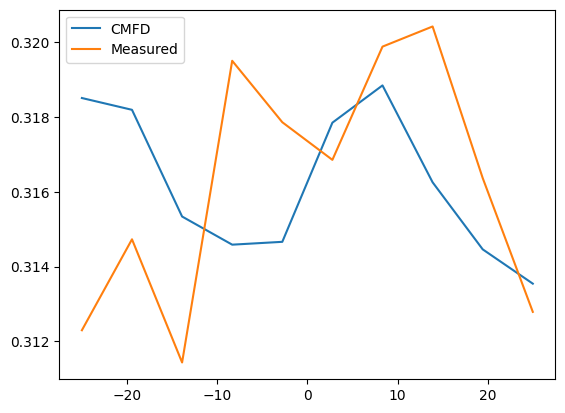

In [29]:
import matplotlib.pyplot as plt

predicted_flux = convert_flattened_flux_into_matrix(mc_flux)
y_flux = predicted_flux[0, :, 0, 0]
grid = np.linspace(-25, 25, mesh_size_y)

plt.plot(grid, y_flux  / np.linalg.norm(y_flux), label="CMFD")

total_flux = np.sum(flux_matrix[:, :, :, 0, 0, 0], axis=0)[:, 0]
plt.plot(grid, total_flux / np.linalg.norm(total_flux), label="Measured")

plt.legend()

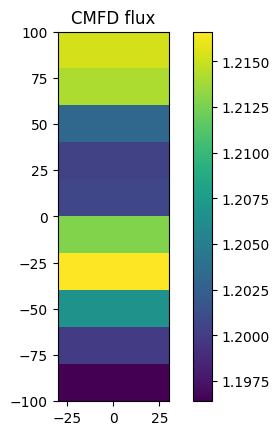

In [30]:
import matplotlib.pyplot as plt

fig, (ax1) = plt.subplots(1, 1, sharey=True)

predicted_flux = convert_flattened_flux_into_matrix(mc_flux)
total_flux = np.sum(predicted_flux[:, :, :, 0], axis=2).T
img1 = ax1.imshow(total_flux, extent=[-30, 30, -100, 100])

ax1.set_title("CMFD flux")

fig.colorbar(img1)

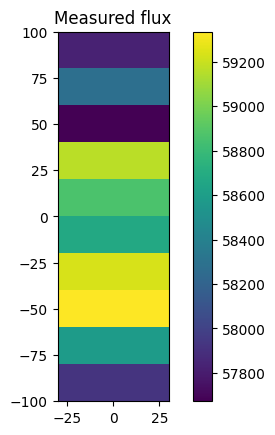

In [31]:
import matplotlib.pyplot as plt

fig, (ax1) = plt.subplots(1, 1, sharey=True)

total_flux = np.sum(flux_matrix[:, :, :, 0, 0, 0], axis=0)
img1 = ax1.imshow(total_flux, extent=[-30, 30, -100, 100])

ax1.set_title("Measured flux")

fig.colorbar(img1)